<a href="https://colab.research.google.com/github/sourisvs/HEV_Heuristic_Pow_control/blob/main/Final_major_project__code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as grd
from mpl_toolkits.mplot3d import axes3d
from random import seed
from random import random
from math import *
from google.colab import files

In [ ]:
# gear shift strategy speed based
def gear(W):
  #limiting condition for 3754.02 RPM at engine
  #gives max 32 KW
  #first gear rpm 
  if (W<279.18):
    g = 1
  #second gear upto
  elif ((W>=279.18) & (W<496.036)):
    g = 2
  #third gear upto 
  elif ((W>=496.036) & (W<749.5009)):
    g = 3
  #fourth gear upto 
  elif ((W>=749.5009) & (W<996.021)):
    g = 4
  else:
    g = 5
  gr = np.array([13.45,7.57,5.01,3.77,2.837])
  return (g,gr[g-1])

In [ ]:
#function to get engine characteristics
def eng_char_index(WE,p_dem):
  #no engine speed implies no emissions
  if (WE == 0):
    nox = 0
    fcg = 0
    hcg = 0
    return (fcg,nox,hcg)
  w = 0
  min_d = 100000.
  while (fc_rpm[w]<WE):
    w = w+1
  if (p_dem>0):
    #getting shortest distance
    for j in range(len(fc_trq)):
      d = sqrt((fc_rpm[w] - WE)**2 + (pw_map[w][j] - p_dem)**2)
      if (d<min_d):
        min_d = d
        mini = j
    #using point for slope calculation
    #normalizing pw_map for slope:
    slope = np.abs((pw_map[w-1][mini] - p_dem)/(pw_map[w][mini] - pw_map[w-1][mini]))
    #using slope to obtain fc and nox values:
    #insert nox here
  elif (p_dem<=0):
    mini = 0 
    #assume its in neutral and no torque is extracted (minimum torque line)
    if (w==0):
      slope = WE/fc_rpm[w]
    else:
      slope = (WE-fc_rpm[w-1])/(fc_rpm[w] - fc_rpm[w-1])
  #----------------------------------------------------------------------------
  #now obtaining values for all variables
  # NOX
  nox = nox_map[w-1][mini] + slope*(nox_map[w][mini] - nox_map[w-1][mini])
  #FC 
  fcg = fc_fcgsmap[w-1][mini] + slope*(fc_fcgsmap[w][mini] - fc_fcgsmap[w-1][mini])
  #HC 
  hcg = fc_hcgsmap[w-1][mini] + slope*(fc_hcgsmap[w][mini] - fc_hcgsmap[w-1][mini])
  fcg = np.abs(fcg)
  nox = np.abs(nox)
  hcg = np.abs(hcg)
  return (fcg,nox,hcg)

In [ ]:
#motor torque checking
#gets input power, then soc
def motor_torque(wm,p_mot,SOC):
  vmax = 16.5 #max voltage to system
  #convert motor rpm to speed:
  if (wm == 0):
    return (0,0)
  else : 
    WM = wm*(2*pi)/60
  #demand electric torque
    tdem = p_mot/WM
    w=0
    while (ess_soc[w]<SOC):
      w = w+1
    if (p_mot>=0):
    #for motor torque 
    #search for speed, then use power eqn to get it (74.6KW)
      if (WM<275.2035):
        t_mot = 271.1368
      else:
        t_mot = 74600/WM
     #for max battery torque:
      sl = (ess_pow[w] - ess_pow[w-1])/(ess_soc[w]-ess_soc[w-1])
      pm_bat = ess_pow[w-1] + sl*(SOC-ess_soc[w-1])
      tm_bat = pm_bat/WM
      t_motor = min(tm_bat,tdem,t_mot)
      p_motor = t_motor*WM
      return (p_motor,t_motor)
    elif (p_mot<0):
    #for max battery charging power
      sl = (ess_rch[w] - ess_rch[w-1])/((ess_soc[w] - ess_soc[w-1]))
      r_ch = ess_rch[w-1] + sl*((SOC-ess_soc[w-1]))
      p_rch = -(vmax**2)/r_ch
      t_rch = p_rch/WM
    #for max motor power
      if (WM<275.2035):
        t_mot = -271.1368
      else:
        t_mot = -74600/WM
      t_motor = max(t_mot,t_rch,tdem)
      p_motor = t_motor*WM
      return (p_motor,t_motor)

In [ ]:
#code to calculate SOC change
def motor_char(wm,soc,pm):
  if (pm==0):
    return soc
  else :
    w = 0
    min_d = 100000.
    mini = 0
    while (mc_rpm[w]<wm):
      w = w+1
    for j in range(len(mc_trq)):
      d = sqrt((mc_rpm[w] - wm)**2 + (mc_opmap[w][j] - pm)**2)
      if (d<min_d):
        min_d = d
        mini = j
    #using point for slope calculation
    # compensation for in case 2 consecutive points are equal:
    # to prevent slope from going to infinity
    while (mc_opmap[w][mini] == mc_opmap[w-1][mini]):
      mini = mini + 1
    #normalizing pw_map for slope:
    slope = np.abs((mc_opmap[w-1][mini] - pm)/(mc_opmap[w][mini] - mc_opmap[w-1][mini]))
    #using slope to get input power from battery
    mpwi = mc_ipmap[w-1][mini] + slope*(mc_ipmap[w][mini] - mc_ipmap[w-1][mini])
    # converting to KW
    mpwi = mpwi/1000
    #using this power to obtain SOC:
    k = 0
    while (ess_soc[k]<soc):
      k = k+1
    #calculating Voc
    slv = (ess_voc[k] - ess_voc[k-1])/(ess_soc[k] - ess_soc[k-1])
    voc = ess_voc[k-1] + slv*(soc - ess_soc[k-1])
    #calculating soc based on regen or charge
    if (pm<0):
      slr = (ess_rch[k] - ess_rch[k-1])/(ess_soc[k] - ess_soc[k-1])
      r_ch = ess_rch[k-1] + slr*(soc -ess_soc[k-1])
      SOC = soc - (voc - sqrt((voc**2 - 4*mpwi*r_ch)))/(4*r_ch*25)
    else :
      sld = (ess_dch[k] - ess_dch[k-1])/(ess_soc[k] - ess_soc[k-1])
      d_ch = ess_dch[k-1] + sld*(soc -ess_soc[k-1])
      SOC = soc - (voc - sqrt((voc**2 - 4*mpwi*d_ch)))/(4*d_ch*25)
    return SOC

In [ ]:
Driv_cyc = files.upload()

Saving Highway2.csv to Highway2.csv


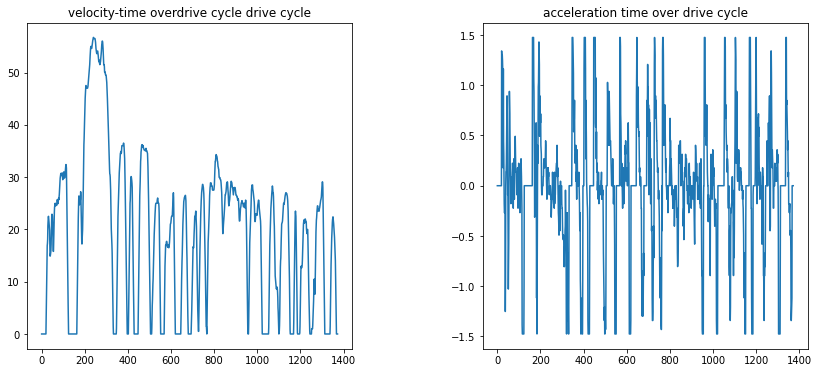

In [ ]:
df = pd.read_csv(io.BytesIO(Driv_cyc['Highway2.csv']))
x=pd.DataFrame(df['Speed'])
v = x.to_numpy()
vmax = max(v)
v_SI = 0.44704*v
acc = np.zeros(len(v))
for i in range(len(v)-1):
  acc[i] = (v_SI[i+1]-v_SI[i])
veloc = np.zeros(4*len(v))
fig1 = plt.figure(figsize=(14,6))
g1 = grd.GridSpec(1,2,figure = fig1,wspace = 0.4,hspace = 0.1) 
ax1 = plt.subplot(g1[0])
ax2 = plt.subplot(g1[1])
ax1.plot(v)
ax1.set_title("velocity-time overdrive cycle drive cycle")
ax2.plot(acc)
ax2.set_title("acceleration time over drive cycle")
ax1.grid(False)
ax2.grid(False)

In [ ]:
fc_pow = files.upload()
fc_nox = files.upload()
fc_eff = files.upload()
fc_fcgs = files.upload()
fc_hcgs = files.upload()
#motor look up tables
mc_ipw = files.upload()
mc_eff = files.upload()

Saving fc_pow.csv to fc_pow.csv


Saving nox_gs.csv to nox_gs.csv


Saving fc_eff.csv to fc_eff.csv


Saving fc_gs.csv to fc_gs.csv


Saving hc_gs.csv to hc_gs.csv


Saving mc_ipw.csv to mc_ipw.csv


Saving mceff.csv to mceff.csv


In [ ]:
#obtain dataframe from uploaded files
df1 = pd.read_csv(io.BytesIO(fc_pow['fc_pow.csv']))
df2 = pd.read_csv(io.BytesIO(fc_nox['nox_gs.csv']))
df3 = pd.read_csv(io.BytesIO(fc_eff['fc_eff.csv']))
df4 = pd.read_csv(io.BytesIO(fc_fcgs['fc_gs.csv']))
df5 = pd.read_csv(io.BytesIO(fc_hcgs['hc_gs.csv']))
df6 = pd.read_csv(io.BytesIO(mc_ipw['mc_ipw.csv']))
df7 = pd.read_csv(io.BytesIO(mc_eff['mceff.csv']))
#get lookup table to numpy array
pw_map = df1.to_numpy()
nox_map = df2.to_numpy()
fc_effmap = df3.to_numpy()
fc_fcgsmap = df4.to_numpy()
fc_hcgsmap = df5.to_numpy()
mc_ipmap = df6.to_numpy()
mc_eff = df7.to_numpy()
#output power of motor:
mc_opmap = mc_ipmap*mc_eff

In [ ]:
#car parameters definition
M = 1550.
J = 3.36
Cd = 0.335
rho = 1.2
Af = 2.
c_roll = 0.009
r = 0.282
Mr = M + J/(r**2)
#engine properties
fc_trq = np.array([6.8, 13.6,20.4,27.2,33.8,40.6,47.4,54.2,61,67.8,74.6,81.4])
fc_rpm = np.array([997.9015,1424.755,2109.44,2793.169,3476.899,4160.629,4845.313,5273.122,5699.975])
#motor properties
mc_trq = np.array([-271.137,-244.0232,-216.909,-189.796,-162.682,-135.568,-108.455,-81.341,-54.227,-27.114,
                   0,27.114,54.227,81.341,108.455,135.568,162.682,189.796,216.909,244.0232,271.137])
mc_spd = np.array([0.,104.720,209.4395,314.159,418.879,523.599,628.319,733.038,837.758,942.478,1047.198])
mc_rpm = np.array([0.,1000.,2000.,3000.,4000.,5000.,6000.,7000.,8000.,9000.,10000.])
mc_gent = np.array([-271.137,-271.137,-271.137,-237.516,-178.137,-142.482,-118.758,-101.812,-89.068,-79.172,-71.173])
mc_maxt = mc_gent*(-1)
#battery properties
V_max = 16.5
ess_voc = np.array([11.7,11.85,11.96,12.11,12.26,12.37,12.48,12.59,12.67,12.78,12.89])
ess_pow = np.array([513.514,603.378,691.420,921.747,1358.549,1805.629,2161.069,2386.585,2573.932,2640.678,2639.754])
ess_rch = np.array([0.0316,0.0298,0.0295,0.0287,0.028,0.0269,0.0231,0.025,0.0261,0.0288,0.0472])
ess_dch = np.array([0.0407,0.037,0.0338,0.0269,0.0193,0.0151,0.0131,0.0123,0.0117,0.0118,0.0122])
ess_soc = np.arange(0.,1.1,0.1)
#getting module power output from cell power
ess_pow = 25*ess_pow
#transmission characteristics
fd = 1.
#torque coupling speed split
mc_fc_spd_rat = 1.7368
#########
#engine modes parameters: (kW)
eng_cutoff = 4.5
hyb_on = 17.1
eng_lim = 38.

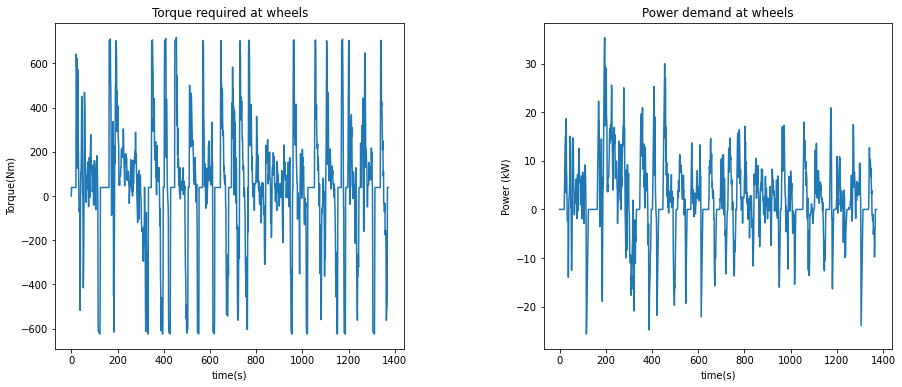

In [ ]:
P_dem = np.zeros(len(v))
T_wh = np.zeros(len(v))
w_wh = np.zeros(len(v))
for i in range(1,len(v)):
  Fd = c_roll*M*9.81
  Fa = 0.5*rho*Af*Cd*(v_SI[i]**2)
  Fr = Fd + Fa
  dv = v_SI[i] - v_SI[i-1]
  T_wh[i] = r*(Fr + dv*Mr)
  w_wh[i] = 60*v_SI[i]/(2*pi*r)
  P_dem[i] = 2*pi*(w_wh[i]*T_wh[i])/60.
P_dem = P_dem/1000
fig2 = plt.figure(figsize=(15,6))
g1 = grd.GridSpec(1,2,figure = fig2,wspace = 0.4,hspace = 0.1) 
ax1 = plt.subplot(g1[0])
ax2 = plt.subplot(g1[1])
ax1.plot(T_wh)
ax1.set_xlabel("time(s)")
ax1.set_ylabel("Torque(Nm)")
ax1.set_title("Torque required at wheels")
ax2.plot(P_dem)
ax2.set_title("Power demand at wheels")
ax2.set_xlabel("time(s)")
ax2.set_ylabel("Power (kW)")
ax1.grid(False)
ax2.grid(False)

In [ ]:
tx = np.zeros(len(T_wh))
shift = np.zeros(len(T_wh))
we = np.zeros(len(T_wh))
wm = np.zeros(len(T_wh))
fc = np.zeros(len(T_wh))
nx = np.zeros(len(T_wh))
hc = np.zeros(len(T_wh))
#engine and motor power 
p_eng = np.zeros(len(T_wh))
p_mot = np.zeros(len(T_wh))
p_break = np.zeros(len(T_wh))
#initialize SOC to 99%
soc = np.full(len(T_wh),0.99)

In [ ]:
#condition for power split
for i in range(1,len(T_wh)):
  g_r = gear(w_wh[i])
  tx[i] = T_wh[i]/g_r[1]
  we[i] = w_wh[i]*g_r[1]
  wm[i] = mc_fc_spd_rat*we[i]
  shift[i] = g_r[0]
  if ((soc[i-1]<0.5)&(soc[i-1]>0.45)):
    mode = 0
  elif (soc[i-1]<0.45):
    mode = -1
  else :
    mode = 1
#case 0 : regenerative breaking:
  if (P_dem[i]<=0):
    if (soc[i-1]<0.85):
      p_mdem = P_dem[i]*1000
      motor_pow = motor_torque(wm[i],p_mdem,soc[i-1])
      p_mot[i] = motor_pow[0]
      p_break[i] = P_dem[i] - p_mot[i]/1000
    else : 
      p_break[i] = P_dem[i]
#case 1 : motor only mode (startup)
  elif ((P_dem[i]>0)&(P_dem[i]<=eng_cutoff)):
    if (mode!=(-1)):
      p_mdem = P_dem[i]*1000
      motor_pow = motor_torque(wm[i],p_mdem,soc[i-1])
      p_mot[i] = motor_pow[0]
      p_eng[i] = P_dem[i] - p_mot[i]/1000
    #if battery charge is critical
    else :
      p_eng[i] = P_dem[i] 
#case 2 : engine only mode during optimal operation
  elif ((P_dem[i]>eng_cutoff)&(P_dem[i]<=hyb_on)) : 
    if (mode == 1):
      p_eng[i] = P_dem[i] 
    else :
      #dummy input power to get rechargin gpower at that point
      dummy = -100000 
      motor_pow = motor_torque(wm[i],dummy,soc[i-1])
      p_mot[i] = motor_pow[0]
      p_eng[i] = P_dem[i] - p_mot[i]/1000
# case 3 : hybrud mode beyond engine optimal region    
  elif (P_dem[i]>hyb_on):
    if (P_dem[i]>eng_lim):
      p_mot[i] = P_dem[i] - hyb_on
      p_eng[i] = hyb_on
    else:
      if (mode!=(-1)):
        mot = (P_dem[i] - hyb_on)*1000
        motor_pow = motor_torque(wm[i],mot,soc[i-1])
        p_mot[i] = motor_pow[0]
        p_eng[i] = P_dem[i] - p_mot[i]/1000
      else : 
        p_eng[i] = P_dem[i]
  #now obtaining the characteristics after power split is implemented
  soc[i] = motor_char(wm[i],soc[i-1],p_mot[i])
  eng_par = eng_char_index(we[i],p_eng[i])
  fc[i] = eng_par[0]
  nx[i] = eng_par[1]
  hc[i] = eng_par[2]
  p_mot[i] = p_mot[i]/1000

Text(0.5, 1.0, 'Engine Power')

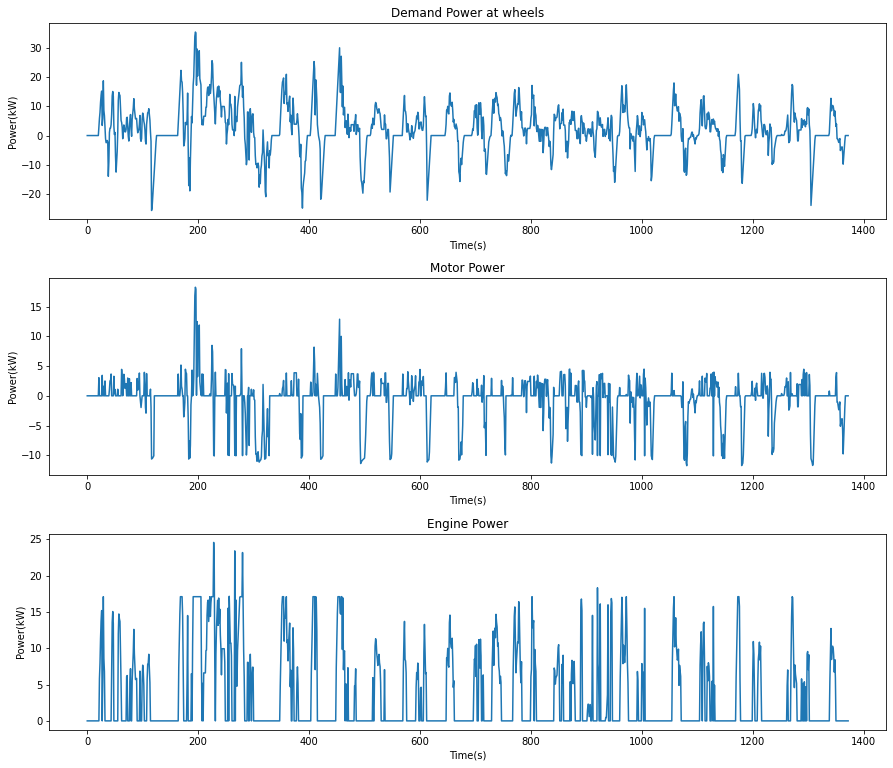

In [ ]:
fig10 = plt.figure(figsize=(15,13))
g1 = grd.GridSpec(3,1,figure = fig2,wspace = 0.4,hspace = 0.3) 
ax1 = plt.subplot(g1[0])
ax2 = plt.subplot(g1[1])
ax3 = plt.subplot(g1[2])
ax1.plot(P_dem)
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Power(kW)")
ax1.set_title("Demand Power at wheels")
ax2.plot(p_mot)
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Power(kW)")
ax2.set_title("Motor Power")
ax3.plot(p_eng)
ax3.set_xlabel("Time(s)")
ax3.set_ylabel("Power(kW)")
ax3.set_title("Engine Power")

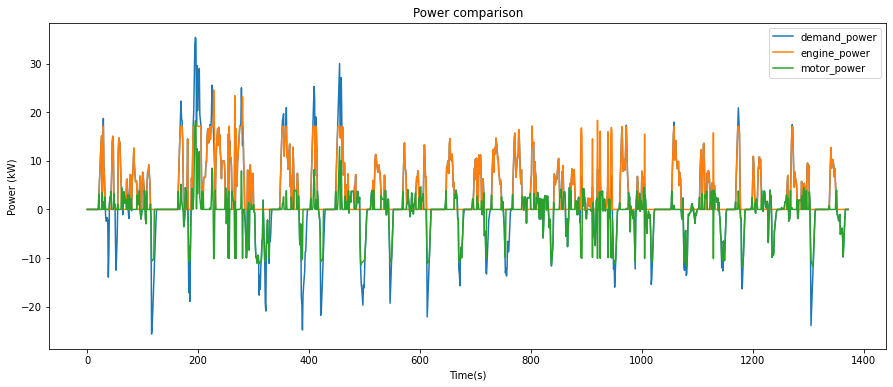

In [ ]:
figure = plt.figure(figsize=(15,6))
plt.plot(P_dem,label="demand_power")
plt.plot(p_eng,label="engine_power")
plt.plot(p_mot,label="motor_power")
plt.title("Power comparison")
plt.ylabel("Power (kW)")
plt.xlabel("Time(s)")
plt.legend()

Final SOC is :  63.10965084469058 %
0.4315280839272404


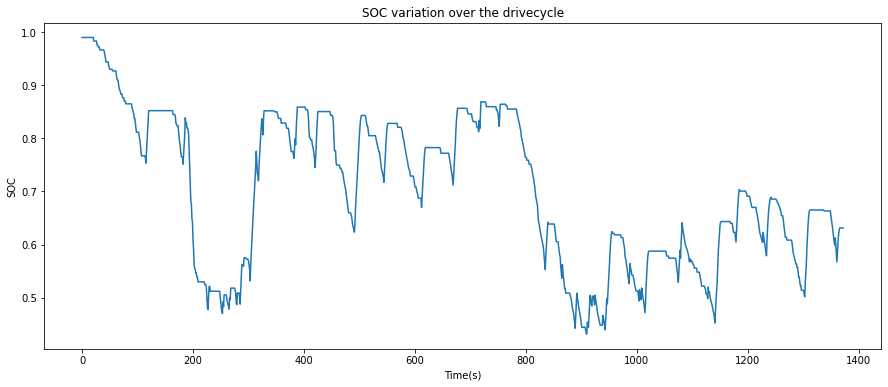

In [ ]:
fig7 = plt.figure(figsize=(15,6))
plt.plot(soc)
plt.title("SOC variation over the drivecycle")
plt.ylabel("SOC")
plt.xlabel("Time(s)")
print("Final SOC is : ",soc[len(soc)-1]*100,"%")
print(min(soc))

Overall fuel consumption : 686.3143392416109 g
Average fuel consumption over the drivecycle  0.49986477730634443 g/s


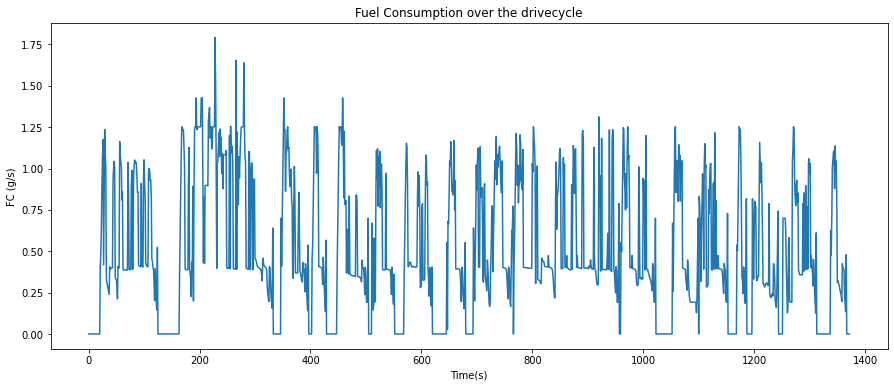

In [ ]:
fig4 = plt.figure(figsize=(15,6))
plt.plot(fc)
plt.title("Fuel Consumption over the drivecycle")
plt.ylabel("FC (g/s)")
plt.xlabel("Time(s)")
overall_fc = np.sum(fc)
print("Overall fuel consumption :",overall_fc,"g")
avg_fc = overall_fc/len(fc)
print("Average fuel consumption over the drivecycle ",avg_fc,"g/s")

Overall Hydrocarbon emissions : 7.661612476500767 g
Average Hydrocarbon emissions over the drivecycle  0.005580198453387303 g/s


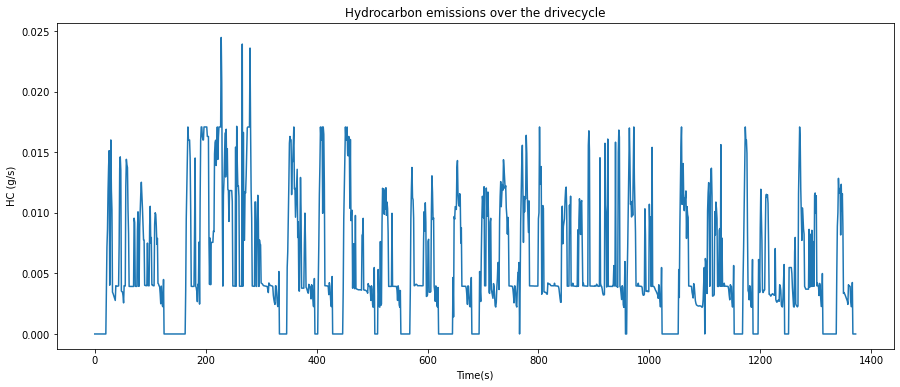

In [ ]:
fig3 = plt.figure(figsize=(15,6))
plt.plot(hc)
overall_hc = np.sum(hc)
plt.title("Hydrocarbon emissions over the drivecycle")
plt.ylabel("HC (g/s)")
plt.xlabel("Time(s)")
print("Overall Hydrocarbon emissions :",overall_hc,"g")
avg_hc = overall_hc/len(hc)
print("Average Hydrocarbon emissions over the drivecycle ",avg_hc,"g/s")

Overall NOx emissions : 17.19326031380548 g
Average NOx over the drivecycle  0.012522403724548785 g/s


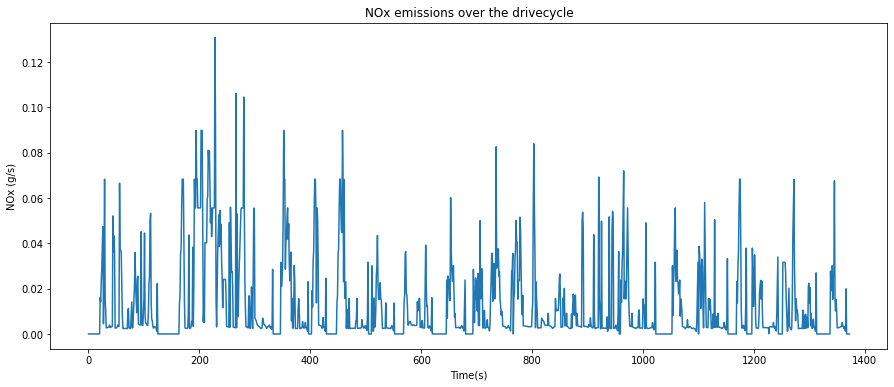

In [ ]:
fig5 = plt.figure(figsize=(15,6))
plt.plot(nx)
overall_nc = np.sum(nx)
plt.title("NOx emissions over the drivecycle")
plt.ylabel("NOx (g/s)")
plt.xlabel("Time(s)")
print("Overall NOx emissions :",overall_nc,"g")
avg_nx = overall_nc/len(nx)
print("Average NOx over the drivecycle ",avg_nx,"g/s")

Text(0, 0.5, 'Selected Gear')

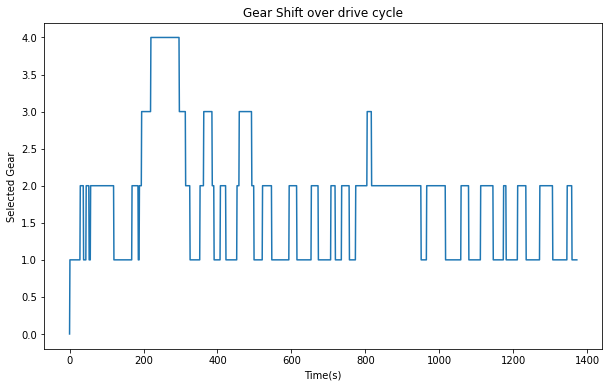

In [ ]:
fig6 = plt.figure(figsize=(10,6))
plt.plot(shift)
plt.title("Gear Shift over drive cycle")
plt.xlabel("Time(s)")
plt.ylabel("Selected Gear")